In [ ]:
# !pip install geopandas
# ! pip install matplotlib
# ! pip install plotly==5.14.1
# ! pip install scipy

In [4]:
# 計算・ハンドリング
import numpy as np
import pandas as pd

# 地理情報操作
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [22]:
# デモ用ポリゴンを定義

# 凸
p1 = Polygon([(0,0), (1,0), (2,0), (2,1), (2,2), (3,2), (4,2), (4,3), (4,4), (3,4), (2,4), (2,5), (2,6), (1,6), (0,6), (0,5), (0,4), (0,3), (0,2), (0,1) ])

# 凹
p2 = Polygon([(5,0), (6,0), (7,0), (8,0), (9,0), (9,1), (9,2), (9,3), (9,4), (9,5), (9,6), (8,6), (7,6), (6,6), (5,6), (5,5), (5,4), (6,4), (7,4), (7,3), (7,2), (6,2), (5,2), (5,1) ])

g = GeoSeries([p1, p2])
g

0    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 2....
1    POLYGON ((5.00000 0.00000, 6.00000 0.00000, 7....
dtype: geometry

<Axes: >

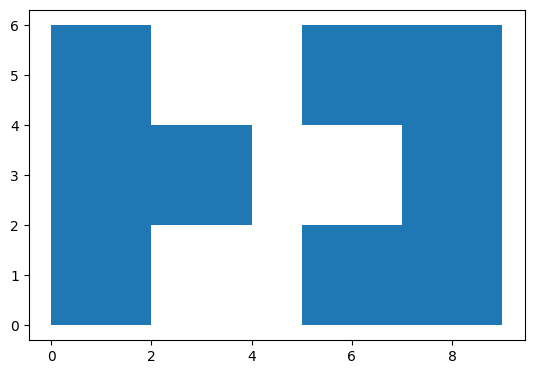

In [23]:
g.plot()

In [27]:
# GeoSeries to GeoDataFrame
gdf = gpd.GeoDataFrame({
      "geometry":g
})
gdf

,geometry
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 2...."
1,"POLYGON ((5.00000 0.00000, 6.00000 0.00000, 7...."


In [28]:
# ポリゴンの外周を取得する
gdf.geometry = gdf.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))

<Axes: >

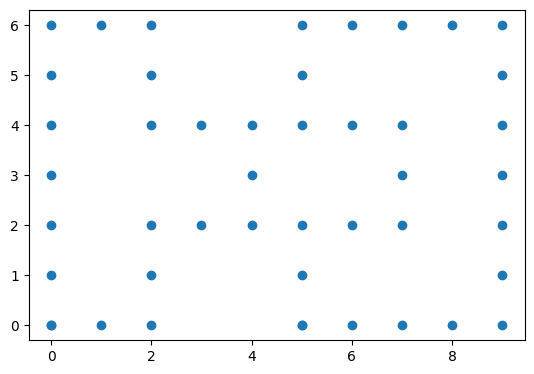

In [29]:
gdf.plot()

In [34]:
# 輪郭の点群をDataframeとして取得する
# 終点が追加されて+1行となる
# ポリゴンごとにIDを付与してくれているので、どのポリゴンの点なのか識別できる
ex = gdf.geometry.explode(index_parts=True)

In [38]:
# GeoSeries to pd.DataFrame
df = pd.DataFrame({
      "x":ex.x,
      "y":ex.y
}).reset_index(drop=False)

In [40]:
# level_0: ポリゴン分類
# level_1: 点NO
df.head()

,level_0,level_1,x,y
0,0,0,0.0,0.0
1,0,1,1.0,0.0
2,0,2,2.0,0.0
3,0,3,2.0,1.0
4,0,4,2.0,2.0


## 手順
1. 局所方向符号を計算
2. 局所曲率符号を計算
3. G-オペレーション

In [ ]:
# 局所方向符号を定義する
# Cn_secがもとまる
cn_list = []
for c in range(df.shape[0] - 1):
      cc = c + 1
      if cc < df.shape[0] - 1:
            fir = df.loc[cc-1,:].values
            sec = df.loc[cc,:].values
            thr = df.loc[cc+1,:].values
      else:
            fir = df.loc[cc-1,:].values
            sec = df.loc[cc,:].values
            thr = df.loc[1,:].values

      v1 = sec - fir
      v2 = thr - sec

      n1 = np.linalg.norm(v1, ord=2)
      n2 = np.linalg.norm(v2, ord=2)

      d = np.dot(v1, v2)

      cos = d / (n1 * n2)

      # Cn_secの角度
      theta = np.arccos(cos)
      theta = np.degrees(theta)
      print("theta", "Cn", cc, theta)

      # 局所方向符号:cn
      if (0 <= theta < 45):
            cn = 0
      elif (45 <= theta < 90):
            cn = 1
      elif (90 <= theta < 135):
            cn = 2
      elif (135 <= theta < 180):
            cn = 3
      elif (180 <= theta < 225):
            cn = 4
      elif (225 <= theta < 270):
            cn = 5
      elif (270 <= theta < 315):
            cn = 6
      elif (315 <= theta < 360):
            cn = 7

      print("局所方向符号", cn)
      cn_list.append(cn)

In [43]:
# 調整
df = df.loc[:df.shape[0] - 2,:]

In [ ]:
cn_list.insert(0, cn_list[-1])
cn_list = cn_list[:-1]
df["Cn"] = cn_list

In [45]:
# 局所曲率符号: ca
# Cai = octmod(Cni - Cni-1 + 11) - 3
ca_list = []
for l in range(len(cn_list)):
      # llは1-8をとる　8をとるとout of range
      ll = l + 1
      if ll < len(cn_list):
            ca = ((cn_list[ll-1] - cn_list[ll] + 11 ) % 8 ) - 3
      else:
            ca = ((cn_list[ll-1] - cn_list[0] + 11 ) % 8 ) - 3
      ca_list.append(ca)

In [ ]:
df["Ca"] = ca_list

In [47]:
def get_range_list(i, k):
      x = [tmp for tmp in range(df.shape[0])]
      xi = x.index(i)

      fir = xi - k
      sec = xi
      thr = xi + k

      if xi - k <= -1:
            under = df.shape[0] + xi - k
            tun = 0
      else:
            under = xi - k
            tun = 1

      if xi + k + 1 >= df.shape[0]:
            upper = xi + k + 1 - df.shape[0]
            tup = 0
      else:
            upper = xi + k + 1
            tup = 1
      if tun * tup == 1:
            r_l = x[under:upper]
      else:
            r_l = x[under:] + x[:upper]

      return r_l

In [86]:
# G-オペレーション
# M: Mは平滑化に用いる曲線上の連続した画素数
# Gi: 曲線の曲率半径が小さいほど、絶対値が大きくなる。
# 絶対値が大きい部分が曲線の角の部分であると考えられる
# +が左回り, -が右回り

M = 2
k = M - 1
s = 0
gi_list = []
for i in range(df.shape[0]):
      r_l = get_range_list(i, k)
      c = r_l.index(i)

      # CnとCaの値を抽出する
      tmp = df.loc[r_l, :]

      for tk in range(M-1) :
            ca_under = tmp.loc[r_l[c - tk], "Ca"]
            ca_upper = tmp.loc[r_l[c + tk], "Ca"]
            # print(ca_under, ca_upper)
            s = (M - k+1) * (ca_under + ca_upper) + s

      Gi = M * tmp.loc[i, "Ca"]  + s
      print(Gi)
      gi_list.append(Gi)

12
2
10
2
10
2
10
2
10
2
10
2
10
2
10
8
8
8
8
-4
0
12
8
8
2
10
8
8
8
8
2
10
8
8
2
10
2
10
2
10
2
10
2
10
-4


In [87]:
df["Gi"] = gi_list

/tmp/ipykernel_530/4219537669.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
df

,level_0,level_1,x,y,Cn,Ca,Gi
0,0,0,0.0,0.0,2,2,12
1,0,1,1.0,0.0,0,-1,2
2,0,2,2.0,0.0,1,1,10
3,0,3,2.0,1.0,0,-1,2
4,0,4,2.0,2.0,1,1,10
5,0,5,3.0,2.0,0,-1,2
6,0,6,4.0,2.0,1,1,10
7,0,7,4.0,3.0,0,-1,2
8,0,8,4.0,4.0,1,1,10
9,0,9,3.0,4.0,0,-1,2


## 判定

In [89]:
df_l0 = df[df["level_0"] == 0]
df_l1 = df[df["level_0"] == 1]

<Axes: >

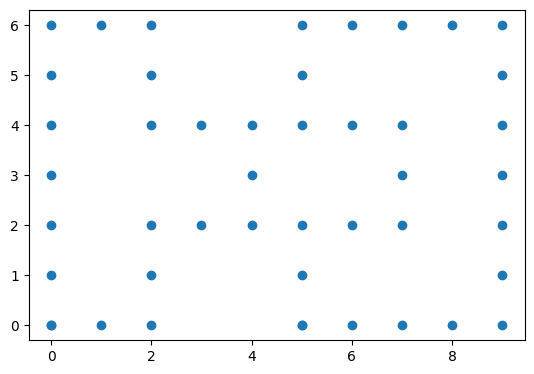

In [90]:
gdf.plot()

In [93]:
import plotly.express as px
# df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df_l0, x="level_1", y="Gi", color="level_0", text="x")
fig.update_traces(textposition="bottom right")
fig.show()

"""
シンプルな形だと、Giでは特徴が掴みづらい。可能性
Ca, Giを利用すると、パズル的に形状が一致する部分は完全に一致する波形を取ることを確認した。
90度に曲がられるといまいち分かりずらい
"""

'\nシンプルな形だと、Giでは特徴が掴みづらい。\nCaを利用すると、パズル的に形状が一致する部分は完全に一致する波形を取ることを確認した。\n90度に曲がられるといまいち分かりずらい\n\n\n'

In [94]:
import plotly.express as px
# df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df_l1, x="level_1", y="Gi", color="level_0", text="x")
fig.update_traces(textposition="bottom right")
fig.show()

In [96]:
import plotly.express as px

# df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="level_1", y="Gi", color="level_0", text="x")
fig.update_traces(textposition="bottom right")
fig.show()

In [100]:
"""
一致判定方法（案）

Q. 近似的な一致に対応できるか
Q.


1. 一方のポリゴンをずらしていいって、Giの二条和誤差が最小となるずらし回数を算出
2. 相互相関係数: 配列の長さの差に対応できない。。
3.
"""

'\n一致判定方法（案）\n\nQ. 近似的な一致に対応できるか\nQ.\n\n\n1. 一方のポリゴンをずらしていいって、Giの二条和誤差が最小となるずらし回数を算出\n2. ラグ相関係数\n'